> Tutorial from [here](https://arc.net/l/quote/yxopkikd)

# 10.12. Equivariant Neural Networks with Constraints¶

You do not need to use irreducible representations. It is currently in 2022 the dominant paradigm due to its good accuracy. One alternative is to work in the defining/faithful representation and put equivariant constraints on your network weights. This approach is quite nice because the implementation is independent of the group. It also works for finite groups. Let’s see an example of this approach via the library released by the authors called Equivariant MLP (emlp)[FWW21]

We’ll create an SO(3) equivariant neural network and check that it is equivariant to rotations. We begin by defining our group and its representation. I’ll show a few elements too, to demonstrate that this is the faithful representation and not the irreducible.

In [23]:
from emlp.groups import SO, S, Z
import emlp.reps as reps
import emlp
# import haiku as hk
# import emlp.nn.haiku as ehk
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt

G = SO(3)
G = Z(3)

so3_rep = reps.V(G)
# grab a random group element
sampled_g = G.sample()
dense_rep = so3_rep.rho(sampled_g)
# check its a member of SO(3)
# g @ g.T = I
print(dense_rep @ dense_rep.T)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


Now we’ll apply our group element to a point to see it rotate the point. The norm should be unchanged, because it’s a rotation.

In [24]:
point = np.array([0, 0, 1])
print("new point", dense_rep @ point.T)
print("norm", np.sqrt(np.sum((dense_rep @ point) ** 2)))

new point [0. 0. 1.]
norm 1.0


Now let’s assume our input function consists of 5 points (e.g., methanol molecule) defined by features (e.g., 1D element embedding) and positions. We’ll create that as a direct sum of 5 scalars and 5 vectors. Our output will be a vector (e.g., dipole). Equivariance here will then mean that if rotate the input points, our output vector should undergo the same rotation.



In [25]:
input_rep = 5 * so3_rep**0 + 5 * so3_rep**1
print("input rep", input_rep)
print("output rep", so3_rep)

input_point = np.random.randn(5 + 5 * 3)
print("input features", input_point[:5])
print("input positions\n", input_point[5:].reshape(5, 3))

input rep 5V⁰+5V
output rep V
input features [-0.35448665  1.59553971  2.17042655  0.45754198 -0.1137788 ]
input positions
 [[-0.60548318 -0.88854923 -0.36149914]
 [ 2.04598107  2.09122305  0.25649913]
 [ 0.80348364  0.86466423  0.25958641]
 [-0.22587599  0.66790673  0.48966497]
 [ 0.3770598   1.10139139 -0.10159097]]


In [26]:
model = emlp.nn.EMLP(input_rep, so3_rep, group=G, num_layers=1)
output_point = model(input_point)
print("output", output_point)

output [0.06717512 0.06940834 0.07979097]


Now we’ll transform the input points according to a random element in the group. We could convert the input into the five spatial vectors and apply the group element to them individually and put them back together. However, emlp has a convenience function for exactly that. We can change our group element to the input representation.

In [27]:
trans_input_point = input_rep.rho_dense(sampled_g) @ input_point
print("transformed input features", trans_input_point[:5])
print("transformed input positions\n", trans_input_point[5:].reshape(5, 3))

transformed input features [-0.35448664  1.5955397   2.1704266   0.45754197 -0.1137788 ]
transformed input positions
 [[-0.6054832  -0.8885492  -0.36149913]
 [ 2.0459812   2.091223    0.25649914]
 [ 0.80348366  0.86466426  0.25958642]
 [-0.22587599  0.6679067   0.48966497]
 [ 0.3770598   1.1013914  -0.10159097]]


Now we compare running the transformed input through the model against applying the group element to the output from the untransformed input.



In [28]:
model(trans_input_point), sampled_g @ output_point


(Array([0.06717512, 0.06940834, 0.07979097], dtype=float32),
 Array([0.06717512, 0.06940834, 0.07979097], dtype=float32))

Indeed they are equivalent – meaning this model is equivariant. The constraint approach is quite simple to use and can handle arbitrary groups. However, it may not be efficient when working with many input points (like a protein) and it may make sense to use an implementation specific to E(3) or SO(3).



## 10.12.1. How the constraints work
How does this magic happen? Rather than explicitly setting constraints on the dense layer weights, emlp always first projects the network weights into an equivariant subspace. This means that the cost of equivariance is paid when constructing the model when this projection matrix is found but not later during training and inference. The equivariant subspace is the space of allowed weights that respect the equivariance. Let’s see what this looks like.

Recall that a dense layer has the equation:
$$
y=\sigma(W x+b)
$$
where $\sigma$ is a special nonlinearity for equivariant neural networks we won’t discuss here (see [WGW+18]). To respect the equivariance, $W, b$ will need to be projected into an equivariant subspace that depends on our group and input/output representations. So our modified equation would look like:
$$
y=\sigma\left(P_w W x+P_b b\right)
$$

Let’s start by making these projectors. $P_b$ only will need to consider the output rep, since $b$ is the bias (same representation as output).

In [69]:
Pw = (input_rep >> so3_rep).equivariant_projector()
Pb = (so3_rep).equivariant_projector()

print("Pw shape is", Pw.shape, "Pb shape is", Pb.shape)

Pw shape is (60, 60) Pb shape is (3, 3)


Note that they are square because they should leave the underlying dimension of $W$ unchanged – we are not projecting to a reduce dimension, but a subspace within the space of possible values of the weights. Remember too our representations are flattened - that 60 comes from the fact that our weight matrix is 
$3 \times (5 + 15)$.

Now let’s show how these projectors can convert an arbitrary weight matrix into one that is equivariant

In [77]:
W = np.random.randn(3, 5 + 5 * 3)
# W = np.arange(3*(5+5*3)).reshape(3, 5 + 5 * 3)
b = np.random.randn(3)


print(
    "W is not alone equivariant",
    W @ trans_input_point.flatten(),
    "!=",
    sampled_g @ W @ input_point,
)

W is not alone equivariant [ 1.9014758 -2.2255647 -9.842474 ] != [ 1.9014758 -2.2255647 -9.842474 ]


In [78]:
Proj_W = (Pw @ W.flatten()).reshape(W.shape)
print(
    "Projected W is equivariant",
    Proj_W @ trans_input_point.flatten(),
    "==",
    sampled_g @ Proj_W @ input_point,
)

Projected W is equivariant [ 1.4566665  -1.9830605  -0.30825925] == [ 1.4566665  -1.9830605  -0.30825925]


You may be wondering how much the projection affects $W$. Is there enough flexibility that you can learn? We can compare the full random matrix $W$ vs it’s projection.

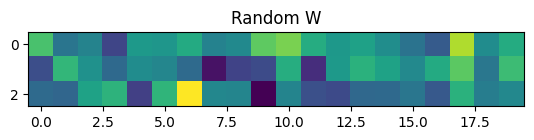

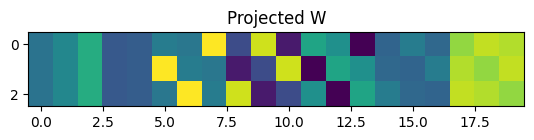

In [79]:
plt.title("Random W")
plt.imshow(W)
plt.show()
plt.title("Projected W")
plt.imshow(Proj_W)
plt.show()

In [80]:
Pw.shape

(60, 60)

In [74]:
Proj_W

Array([[20.000002, 21.000004, 22.000002, 23.000002, 24.000004, 26.000006,
        25.999998, 25.999998, 29.000008, 28.999998, 28.999998, 32.00001 ,
        31.999996, 31.999996, 35.000008, 35.      , 34.999996, 38.00001 ,
        38.      , 37.999996],
       [20.000006, 21.000006, 22.000004, 23.000006, 24.000006, 26.      ,
        26.000011, 25.999994, 29.      , 29.000013, 28.999994, 31.999996,
        32.000015, 31.99999 , 34.999996, 35.000015, 34.999992, 38.      ,
        38.00002 , 37.999996],
       [20.000008, 21.000008, 22.000006, 23.000008, 24.000008, 25.999998,
        25.999998, 26.000002, 28.999998, 28.999998, 29.000004, 31.999994,
        31.999998, 32.000004, 34.999996, 34.999992, 35.      , 37.999996,
        37.999996, 38.000004]], dtype=float32)

In [73]:
Pw2 = np.array(Proj_W)
np.isin(Pw2, W).any()

True

In [37]:
# Example arrays
array1 = np.array([[1, 2, 3], [4, 5, 6]])
array2 = np.array([6, 7, 8, 9])

# Check if any value in array1 is the same as any value in array2
result = np.any(np.isin(array1, array2))
result

True

In [38]:
W.shape, Proj_W.shape

((3, 20), (3, 20))

In [14]:
len(np.unique(np.round(Proj_W, 6)))

23

It appears that there are only a few unique values in $W$ after projection, so that our weight space is effectively much lower dimensional. This is why it’s important to have multiple channels! This also demonstrates why emlp can be more expensive. We’re training 180 values but we could have just used a few. Similarly, the projected bias is zero for our system.

In [15]:
Pb @ b

Array([0.05033465, 0.05033465, 0.05033466], dtype=float32)